# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3 as sq
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from tqdm import tqdm 
import os
from prettytable import PrettyTable
from scipy.sparse import hstack,csr_matrix
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,train_test_split,cross_validate
import matplotlib.pyplot as plt
import seaborn as sn 
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeClassifier,export_graphviz

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# using SQLite Table to read data.
con = sq.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

DatabaseError: Execution failed on sql ' SELECT * FROM Reviews WHERE Score != 3 ': no such table: Reviews

In [15]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [16]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [17]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [18]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [19]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [20]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [21]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [22]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [23]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [24]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [25]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [26]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [27]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [28]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [29]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [30]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [31]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [32]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [47]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [48]:
# Combining all the above pre - processing steps 
from tqdm import tqdm
preprocessed_reviews = []
snowBall = SnowballStemmer('english')
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values,position= 0,mininterval= 1):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(snowBall.stem(words) for words in sentence.split())
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:58<00:00, 1015.13it/s]


In [50]:
preprocessed_reviews[2500]

'salt free season blend great product sanction salt consumpt great flavor much less expens via amazon com store purchas find'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [52]:
## Performing Preprocessing for Summary review.
preprocessed_summary = []
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
for summ_sentence in tqdm(final['Summary'].values):
    summ_sentence = re.sub(r"http\S+","",summ_sentence)
    summ_sentence = BeautifulSoup(summ_sentence, 'lxml').get_text()
    summ_sentence = decontracted(summ_sentence)
    summ_sentence = re.sub("\S*\d\S*", "",summ_sentence)
    summ_sentence = re.sub('[^A-Za-z]+',' ',summ_sentence)
    summ_sentence = ' '.join(snowBall.stem(words) for words in summ_sentence.split())
    summ_sentence = ' '.join(e.lower() for e in summ_sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summ_sentence.strip())


100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:32<00:00, 3926.56it/s]


In [53]:
preprocessed_summary[2500] # preprocessed summary review

'product qualiti'

In [56]:
#Storing the review text and summary with preprocessed values
final['Text'] = preprocessed_reviews
final['Summary'] = preprocessed_summary

#Storing the preprocessed dataframe on HDD
conn = sq.connect('AmazonReviewFiltered.sqlite')
final.to_sql('Reviews', conn,if_exists= 'replace' )

conn = sq.connect('AmazonReviewFiltered.sqlite')
AmazonReviewDataFiltered = pd.read_sql_query("""SELECT * FROM Reviews """, conn)

AmazonReviewDataFiltered.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,love book miss hard cover version,grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup rice month,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,good swingi rhythm read aloud,great littl book read aloud nice rhythm well g...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,great way learn month,book poetri month year goe month cute littl po...


In [57]:
AmazonReviewDataFiltered['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [58]:
# Sampling 100k data points from AmazonREviewDataFiltered to perform BoW, TF - IDF, word2vec and TF - IDF avgerage w2v, to reduce processing time.
AmazonPositiveReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 1].sample(n =84300) # Sampling 84300 positive data points from AmazonReviewDataFiltered, i.e. 84.3%
AmazonNegativeReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 0].sample(n = 15700) # Sampling 15700 negative data points from AmazonReviewDataFiltered, i.e. 15.7%
AmazonReviewDataSampled = AmazonPositiveReviewData.append(AmazonNegativeReviewData, ignore_index= True) # Appending the samples of positive and negative data points to form AmazonReviewDataSampled 
AmazonReviewDataSampled.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,316638,342810,B000ET4SM8,A1CAO6O07L4JJP,Jennifer Morgan,2,2,1,1327363200,veri impress,littl skeptic becaus price great compar find s...
1,379156,409962,B004AWTR6M,A1752DLH60KYMK,MK,0,0,1,1296518400,nice appl flavor aroma,happi sad not bit sweeter not need ani extra s...
2,233172,252927,B000V7MWMG,A1LSXXXNBKKERC,Jill L. Becklund,0,0,1,1307750400,sweet portabl treat,fruit nugget tast great without artifici color...
3,20915,22843,B001EO61AO,A2RZG0KLQWNJAI,OdileK,0,0,1,1313280000,graiss de canard,think sometim look graiss de canard els look a...


In [59]:
AmazonReviewDataSampled.tail(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
99996,91444,99477,B001FA1KU8,AHMLWB0J0L20R,asiel,1,9,0,1336953600,organ,tast regardless whatev chemic not rather pay l...
99997,463313,500979,B004ZWK0CW,A19TZJZGQKO6YE,La Nonna,0,1,0,1315526400,opinion,tast not good halva product purchas past tri b...
99998,454787,491688,B0008D6WBA,A2AC447PRCX38J,"Nevien A. Abdelreheim ""N.Ismaiel""",15,27,0,1197072000,item not actual kosher pig gelatin,particular item not kosher take close look pic...
99999,128280,139201,B000JMDGYG,A2YQ2KG4S1QRDV,Ziminy13,0,3,0,1276992000,disappoint not classic flavor,titl say top color not right either chili colo...


In [60]:
AmazonReviewDataSampled['Score'].value_counts()

1    84300
0    15700
Name: Score, dtype: int64

In [61]:
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled.to_sql('Reviews', conn,if_exists= 'replace' )

In [4]:
con = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [5]:
AmazonReviewDataSampled['Score'].value_counts()

1    84300
0    15700
Name: Score, dtype: int64

In [6]:
# Program to split and sort the positive and negative reviews of the amazon dataset based on time.
AmazonReviewDataSampledPositive = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 1]

AmazonReviewDataSampledNegative = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 0]
# Program to sort the positive and negative review dataset with respect to time.
AmazonReviewDataSampledPositive.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True )
AmazonReviewDataSampledNegative.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True)

In [7]:
AmazonReviewDataSampledPositive.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
82453,82453,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,beetlejuic well written movi everyth excel act...
73877,73877,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,beetlejuic excel funni movi keaton hilari wack...
45999,45999,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,great,one movi movi collect fill comedi action whate...
36656,36656,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,sure death fli,bought apart infest fruit fli onli hour trap a...


In [8]:
AmazonReviewDataSampledNegative.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
84495,84495,417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,992217600,casper ghost,michael keaton bring no distinguish characteri...
97987,97987,333932,361319,B00005IX96,AGUF1WPEG4GSM,"""lchang44""",5,8,0,1055376000,almost expir sept,return due veri short brief expir date sept wo...
91947,91947,388413,419994,B0000A0BS5,A238V1XTSK9NFE,Andrew Lynn,46,59,0,1064361600,not actual use espresso machin,thing would like point espresso not roast drin...
99127,99127,264269,286453,B0000DJ7WI,A375QRG43POEW6,dndnd,23,25,0,1069977600,stay away,product ship great packag look good tast horri...


In [9]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset.
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

In [10]:
AmazonReviewDataSampledTrain.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,82453,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,beetlejuic well written movi everyth excel act...
1,73877,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,beetlejuic excel funni movi keaton hilari wack...
2,45999,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,great,one movi movi collect fill comedi action whate...
3,36656,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,sure death fli,bought apart infest fruit fli onli hour trap a...


In [11]:
AmazonReviewDataSampledTest.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,55827,14163,15461,B004S8X034,A3J0U8JL2NBGD7,Jessica,0,0,1,1328486400,delici,order cupcak mix becaus cowork birthday superv...
1,41995,333151,360495,B000LT0STS,A2YHK2AISUA6B,confettikitty,0,0,1,1328486400,healthi chew gum good flavor,sinc kid love chew sugarless gum read good hab...
2,6230,272370,295202,B001FA1EFO,AE2QBLXC1JVNS,Jess,0,0,1,1328486400,azomg,bought worri would come less satisfactori cond...
3,33133,456220,493264,B003TC7WN4,A3CTXFPNJCCUVO,Keith Corbin,2,2,1,1328486400,favorit k cup,wife decid hand favorit k cup tri lot donut sh...


In [12]:
AmazonReviewDataSampledTrain['Score'].value_counts()

1    59010
0    10990
Name: Score, dtype: int64

In [13]:
AmazonReviewDataSampledTest['Score'].value_counts()

1    25290
0     4710
Name: Score, dtype: int64

In [14]:
AmazonReviewDataSampledTrain_RBF = AmazonReviewDataSampledTrain.sample(40000,random_state= 6)
AmazonReviewDataSampledTrain_RBF.shape

(40000, 12)

# [4] Featurization

## [4.1] BAG OF WORDS

In [15]:
#BoW
#Performing Bag of words vectorizer using sklearn inbuit function countvectorizer for train and test data for review text
bagofwords = CountVectorizer() #in scikit-learn
bagofwords.fit(AmazonReviewDataSampledTrain['Text'])
print("some feature names ", bagofwords.get_feature_names()[:10])
print('='*117)


bowTrain = bagofwords.transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(bowTrain))
print("the shape of our text BOW Train vectorizer ",bowTrain.get_shape())
print("the number of unique words ", bowTrain.get_shape()[1])
print("*"*117)

bowTest = bagofwords.transform(AmazonReviewDataSampledTest['Text'])
print("The shape of our text BOW Test vectorizer:" , bowTest.get_shape())


some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaahhhhhyaaaaaa', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW Train vectorizer  (70000, 35576)
the number of unique words  35576
*********************************************************************************************************************
The shape of our text BOW Test vectorizer: (30000, 35576)


In [16]:
#Standardizing the bag of word vectorizer using Max Absolute scaler since bag of words vectorizer is a CSR matrix
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [17]:
#BoW
#Performing bag of words vectorizer using countvectorizer for train and test data for summary review
bagofwordsSum = CountVectorizer() #in scikit-learn
bagofwordsSum.fit(AmazonReviewDataSampledTrain['Summary'])
print("some feature names ", bagofwordsSum.get_feature_names()[:10])
print('='*117)

bowTrainSum = bagofwordsSum.transform(AmazonReviewDataSampledTrain['Summary'])
print("the type of count vectorizer ",type(bowTrainSum))
print("the shape of our text BOW Train vectorizer ",bowTrainSum.get_shape())
print("the number of unique words ", bowTrainSum.get_shape()[1])
print("*"*117)

bowTestSum = bagofwordsSum.transform(AmazonReviewDataSampledTest['Summary'])
print("The shape of our text BOW Test vectorizer:" , bowTestSum.get_shape())


some feature names  ['aa', 'aaa', 'aaaa', 'aaaaahhh', 'aaaamaz', 'aaah', 'aardvark', 'ab', 'abacor', 'abbi']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW Train vectorizer  (70000, 10479)
the number of unique words  10479
*********************************************************************************************************************
The shape of our text BOW Test vectorizer: (30000, 10479)


In [18]:
#Column standardization
maxscaler = MaxAbsScaler()
bowTrainSum = maxscaler.fit_transform(bowTrainSum)
bowTestSum = maxscaler.transform(bowTestSum)

## [4.2] Bi-Grams and n-Grams.

In [19]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numbers min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [20]:
#Performing TFIDF vectorizer for train and test data using text review
tfidfVec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidfVec.fit(AmazonReviewDataSampledTrain['Text'])
print("some sample features(unique words in the corpus)",tfidfVec.get_feature_names()[0:10])
print('='*117)

tfidfTrain = tfidfVec.transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(tfidfTrain))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrain.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrain.get_shape()[1])
print('*'*117)
tfidfTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTest.get_shape())
print('='*117)

some sample features(unique words in the corpus) ['aa', 'ab', 'abandon', 'abdomin', 'abil', 'abl', 'abl buy', 'abl chew', 'abl drink', 'abl eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (70000, 43594)
the number of unique words including both unigrams and bigrams  43594
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 43594)


In [21]:
#Column standardization
maxscaler = MaxAbsScaler()
tfidfTrain = maxscaler.fit_transform(tfidfTrain)
tfidfTest = maxscaler.transform(tfidfTest)

In [23]:
#TFIDF vectorizer for train and test data for summary review
tfidfVecSum = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidfVecSum.fit(AmazonReviewDataSampledTrain['Summary'])
print("some sample features(unique words in the corpus)",tfidfVecSum.get_feature_names()[0:10])
print('='*117)

tfidfTrainSum = tfidfVecSum.transform(AmazonReviewDataSampledTrain['Summary'])
print("the type of count vectorizer ",type(tfidfTrainSum))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrainSum.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrainSum.get_shape()[1])
print('*'*117)
tfidfTestSum = tfidfVecSum.transform(AmazonReviewDataSampledTest['Summary'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTestSum.get_shape())
print('='*117)

some sample features(unique words in the corpus) ['abl', 'absolut', 'absolut best', 'absolut delici', 'absolut favorit', 'absolut love', 'absolut wonder', 'acai', 'accept', 'accord']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (70000, 3336)
the number of unique words including both unigrams and bigrams  3336
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 3336)


In [24]:
#Column standardization
maxscaler = MaxAbsScaler()
tfidfTrainSum = maxscaler.fit_transform(tfidfTrainSum)
tfidfTestSum = maxscaler.transform(tfidfTestSum)

## [4.4] Word2Vec

In [25]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in AmazonReviewDataSampledTrain['Text']:
    list_of_sentance.append(sentance.split())

In [26]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*117)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrif', 0.8181264400482178), ('excel', 0.8176361322402954), ('awesom', 0.8004711866378784), ('wonder', 0.7878085374832153), ('fantast', 0.7758486270904541), ('good', 0.7648374438285828), ('perfect', 0.7192522287368774), ('nice', 0.6979304552078247), ('fabul', 0.6681197285652161), ('decent', 0.6656626462936401)]
[('best', 0.7953901886940002), ('greatest', 0.7339557409286499), ('nastiest', 0.6889623999595642), ('tastiest', 0.6727986335754395), ('sweetest', 0.6490967869758606), ('crunchiest', 0.5791789293289185), ('softest', 0.5774276256561279), ('smoothest', 0.5649415254592896), ('healthiest', 0.5648146867752075), ('blandest', 0.5630348920822144)]


In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11040
sample words  ['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'funni', 'keaton', 'hilari', 'wacki', 'great', 'help', 'film', 'think', 'one', 'best', 'ever', 'made', 'sure', 'agre', 'good', 'time', 'watch', 'collect', 'fill', 'comedi', 'action', 'whatev', 'els', 'want', 'call', 'bought', 'apart', 'infest', 'fruit', 'fli', 'onli', 'hour', 'trap', 'attract', 'mani', 'within', 'day', 'practic']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v for Text review

In [28]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrain = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrain.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrain),',',len(avgW2VTrain[0]),')')
#column standzrdization
scale = StandardScaler()
avgW2VTrain = scale.fit_transform(avgW2VTrain)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [01:09<00:00, 1007.94it/s]


The shape of avgerage word to vector for Train data  is  ( 70000 , 50 )


In [29]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTest.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTest),',',len(avgW2VTest[0]),')')
avgW2VTest = scale.transform(avgW2VTest)# column standardization

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:31<00:00, 966.96it/s]


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


<b> AVG W2V for Summary

In [30]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrainSum = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain['Summary'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrainSum.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrainSum),',',len(avgW2VTrainSum[0]),')')
#column standardization
scale = StandardScaler()
avgW2VTrainSum = scale.fit_transform(avgW2VTrainSum)

100%|█████████████████████████████████████████████████████████████████████████| 70000/70000 [00:05<00:00, 11867.06it/s]


The shape of avgerage word to vector for Train data  is  ( 70000 , 50 )


In [31]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTestSum = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Summary'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTestSum.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTestSum),',',len(avgW2VTestSum[0]),')')
avgW2VTestSum = scale.transform(avgW2VTestSum)# column standardization

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 12740.27it/s]


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


#### [4.4.1.2] TFIDF weighted W2v for text review


In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(AmazonReviewDataSampledTrain['Text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrain = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrain.append(sent_vec)
    row += 1



100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [13:42<00:00, 85.08it/s]


In [34]:

tfidfw2vTest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTest.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [06:04<00:00, 82.28it/s]


In [35]:
#column standardization
scale = StandardScaler()
tfidfw2vTrain = scale.fit_transform(tfidfw2vTrain)
tfidfw2vTest = scale.transform(tfidfw2vTest)

### TFIDFAVGW2V for summary review

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrixSum = model.fit_transform(AmazonReviewDataSampledTrain['Summary'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrainSum = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain['Summary'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrainSum.append(sent_vec)
    row += 1



100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:19<00:00, 3585.65it/s]


In [37]:

tfidfw2vTestSum = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Summary'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTestSum.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:08<00:00, 3626.80it/s]


In [38]:
#Column standardization
scale = StandardScaler()
tfidfw2vTrainSum = scale.fit_transform(tfidfw2vTrainSum)
tfidfw2vTestSum = scale.transform(tfidfw2vTestSum)

# Applying Decision Trees

In [48]:
def clf(x_train,y_train):
    """Function to determine the optimal depth and minimum samples split for decision tree classifier
    Parameters:
    x_train : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    y_train : actual output
   
    
    
    returns the optimal hyperparameter for the Decision Tree classifier.
    
    """
    cv_scores = np.zeros((7,4)) # list to store the cv scores
    trainscores = np.zeros((7,4))# list to store the train scores
    depth = [1,5,10,50,100,500,1000] # list for hyperparameter tunning 
    min_samples_split = [5,10,100,500] # list for hyperparameter tunning
   # Hyperparameter tunning for Decision tree and initialising the DT classifier
    for x in range(len(depth)):
        print('='*117)
        print("For depth = %r"%depth[x])
        for y in range(len(min_samples_split)):
            classifier = DecisionTreeClassifier(criterion= 'gini',max_depth= depth[x],min_samples_split= min_samples_split[y],random_state= 6,class_weight="balanced")
           #Cross validation using cross_validate function.
            score = cross_validate(estimator= classifier,X=x_train,y=y_train,n_jobs= -1,cv= 10,scoring='roc_auc',return_train_score= True)
            cv_scores[x][y] = score['test_score'].mean()
            trainscores[x][y] = score['train_score'].mean()
            print('min sample split = %r , the auc for train data = %r and cv data = %r'%(min_samples_split[y],np.round(trainscores[x][y],5),np.round(cv_scores[x][y],5)))
    print('='*117)
    #To plot auc of CV and Train data for different values of hyperparameter using heat map.
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    sn.heatmap(cv_scores,annot=True,fmt=".3f",yticklabels= depth,xticklabels=min_samples_split)# heat map for cv score
    plt.ylabel('depth of tree')
    plt.xlabel('min_samples_split')
    plt.title('Heatmap of AUC for CV data')
    plt.subplot(1,2,2)
    sn.heatmap(trainscores,annot=True,fmt=".3f",yticklabels= depth,xticklabels=min_samples_split) # heat map for train score
    plt.ylabel('depth of tree')
    plt.xlabel('min_samples_split')
    plt.title('Heatmap of AUC for Train data')
    a,b = np.where(cv_scores == cv_scores.max())
    a = np.asscalar(a)
    b = np.asscalar(b)
    
    return depth[a],min_samples_split[b] # returning the optimal depth and minimum samples split for Decision tree classifier
    
    
                             
def clfperformance(x_train,y_train,x_test,y_test, min_samples,optimal_depth,vectorizer = 'None',filename = 'None'):
    """Decision tree classifier.
    Parameters:
    x_train  : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    y_train : actual output of x_train
    x_test : array-like or sparse matrix of shape = [n_samples, n_features]. the test data.
    y_test : actual output of x_test
    min_samples : min samples split for Decision tree
    optimal_depth : depth for Decision Tree
    vectorizer : bag of words or TFIDF vectorizer
    filename : filename to store the dot file

    
    """
    model = DecisionTreeClassifier(criterion= 'gini',max_depth= optimal_depth,min_samples_split= min_samples,random_state= 6,class_weight="balanced")
    model = model.fit(x_train,y_train)
    predict = model.predict(x_test) # predict the output
    auc_test = roc_auc_score(y_test,predict) # auc for test data
    auc_train = roc_auc_score(y_train,model.predict(x_train))# auc for train data
    print('AUC for Train data is  ',auc_train,'\n')
    print('AUC for the Test data is  ', auc_test,'\n')
    confusionMatrix = confusion_matrix(y_test,predict) # confusion matrix
    TPR = (confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])) * 100 # calculating the TPR 
    TNR = (confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])) * 100 # calculating the TNR
    fprTest,tprTest,thresholdTest = roc_curve(y_test,predict) # roc curve for test data
    fprTrain,tprTrain,thresholdTrain = roc_curve(y_train,model.predict(x_train))# roc curve for train data
    # Plot of roc curve for test and train data
    plt.figure(figsize=(20,10))
    plt.plot(fprTest,tprTest,label = 'roc of Test data')
    plt.plot(fprTrain,tprTrain,label = 'roc of Train data')
    plt.legend()
    plt.title('Plot of ROC curve for Test and Train data')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    # plot of confusion matrix using heat map
    plt.figure(figsize=(20,10))
    sn.heatmap(confusionMatrix,annot=True,fmt="d")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Heatmap of Confusion matrix')
    print('True positive rate =',TPR)
    print('True negative rate =',TNR)
    #to save dot file using export graphviz for graph plotting of decision tree
    if vectorizer != 'None':
        dot = export_graphviz(model,max_depth= 3,feature_names= vectorizer.get_feature_names(),out_file=filename)
    
    else:
        pass
    
    return auc_test,auc_train,TPR,TNR,model.feature_importances_ 
    
def TopFeatures(numoffeat, vectorizer, coef):
    """Function to print top features in positive and negative class
    
    numoffeat = number of features to print 
    vectorizer = bag of words or TFIDF
    coef: coeficeints of Decision Tree classifier
    
    
    """
    feature_names = vectorizer.get_feature_names()# obtaining the feature names for a particular vectorizer.
    coefs_with_fns = sorted(zip(coef, feature_names))# assigning each weights with its corresponding feature names
    top = coefs_with_fns[:-(numoffeat + 1):-1]
    print("%r Most important features in Positive and Negative Class" % (numoffeat))
    
    print("-"*117)
    table1 = PrettyTable()
    table1.field_names = ['Feature Weight','Feature Name ']
    for (weight,feature_name) in top:
        table1.add_row([np.round(weight,4),feature_name])
    print(table1)

In [49]:
#Pretty table to display the results of Decision Tree using various classifeirs
table = PrettyTable()
table.field_names = ['Vectorizer','Optimal Depth','Min Samples Split','AUC','TPR','TNR']

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

For depth = 1
min sample split = 5 , the auc for train data = 0.62068 and cv data = 0.62068
min sample split = 10 , the auc for train data = 0.62068 and cv data = 0.62068
min sample split = 100 , the auc for train data = 0.62068 and cv data = 0.62068
min sample split = 500 , the auc for train data = 0.62068 and cv data = 0.62068
For depth = 5
min sample split = 5 , the auc for train data = 0.75568 and cv data = 0.74888
min sample split = 10 , the auc for train data = 0.75568 and cv data = 0.74888
min sample split = 100 , the auc for train data = 0.75543 and cv data = 0.74919
min sample split = 500 , the auc for train data = 0.75395 and cv data = 0.74966
For depth = 10
min sample split = 5 , the auc for train data = 0.83119 and cv data = 0.78473
min sample split = 10 , the auc for train data = 0.8304 and cv data = 0.78502
min sample split = 100 , the auc for train data = 0.82259 and cv data = 0.79201
min sample split = 500 , the auc for train data = 0.8145 and cv data = 0.79615
For dept

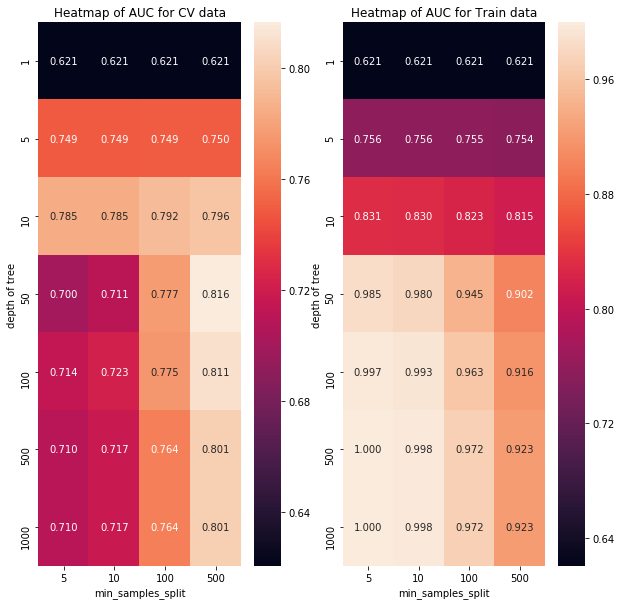

In [50]:
#performing Decision tree classification to find put the optimal depth and minimum samples split.
depth, min_samples = clf(bowTrain,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)


AUC for Train data is   0.8159992314807919 

AUC for the Test data is   0.7545642521275496 



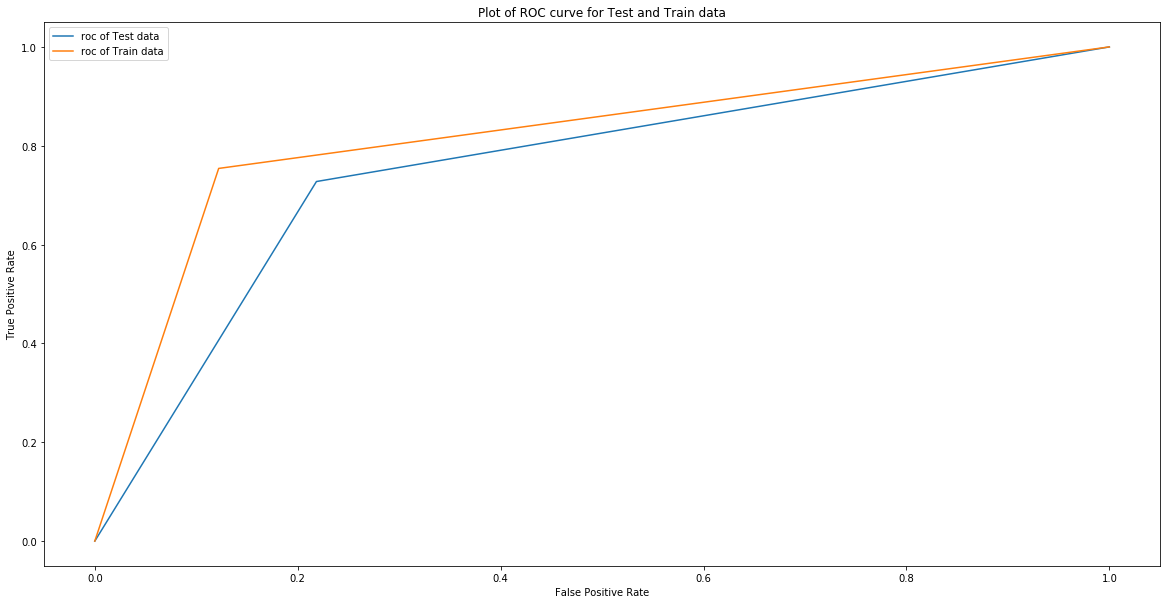

True positive rate = 72.75998418347173
True negative rate = 78.15286624203821


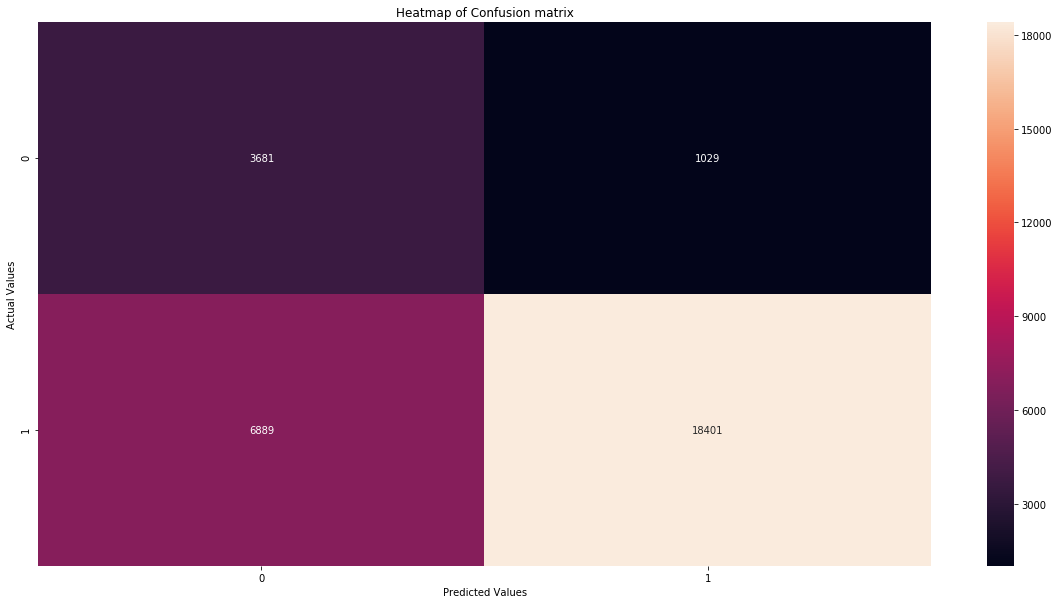

In [51]:
# Decision Tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],min_samples,depth,bagofwords,'bagwords.dot')
table.add_row(['Bag of Words',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [52]:
# Printing the top 20 features of bag of words vectorizer
TopFeatures(20,bagofwords,coef)

20 Most important features in Positive and Negative Class
---------------------------------------------------------------------------------------------------------------------
+----------------+---------------+
| Feature Weight | Feature Name  |
+----------------+---------------+
|     0.1452     |      not      |
|     0.0963     |     great     |
|     0.0594     |   disappoint  |
|     0.0559     |      love     |
|     0.0457     |     delici    |
|     0.0431     |      best     |
|     0.0241     |    perfect    |
|     0.024      |      good     |
|     0.0182     |    favorit    |
|     0.0151     |     excel     |
|     0.0124     |      bad      |
|     0.0121     |    thought    |
|     0.0114     |     tasti     |
|     0.0107     |       aw      |
|     0.0103     |      nice     |
|      0.01      |      tast     |
|     0.0095     |    horribl    |
|     0.0089     |      find     |
|     0.0077     |      amaz     |
|     0.0074     |     would     |
+----------------+-

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

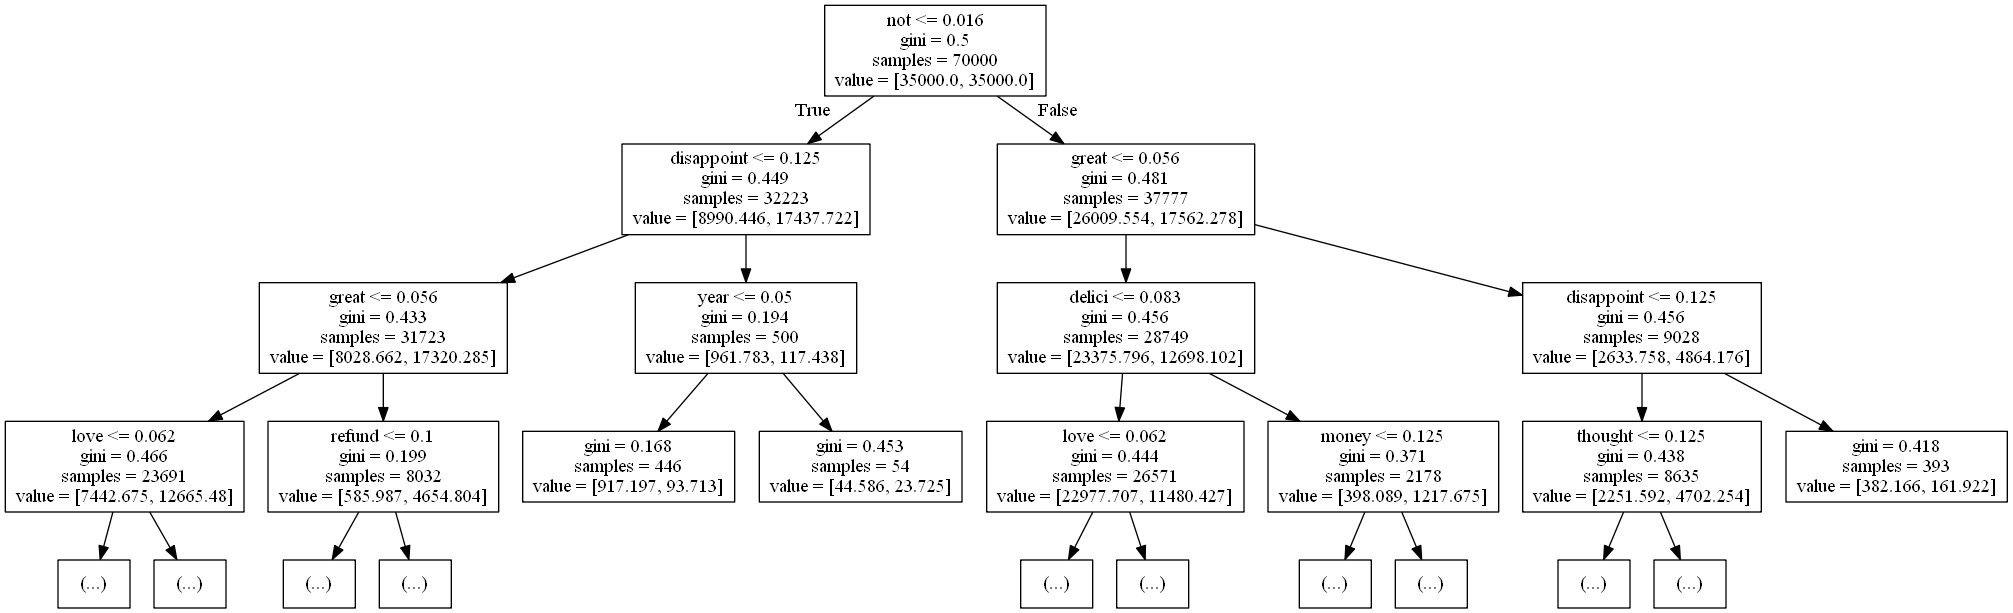

In [79]:
# Graph of decision tree classifier
Image("bagwords.png")

Decision Tree for Bag of words vectorizer

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

For depth = 1
min sample split = 5 , the auc for train data = 0.62388 and cv data = 0.62258
min sample split = 10 , the auc for train data = 0.62388 and cv data = 0.62258
min sample split = 100 , the auc for train data = 0.62388 and cv data = 0.62258
min sample split = 500 , the auc for train data = 0.62388 and cv data = 0.62258
For depth = 5
min sample split = 5 , the auc for train data = 0.76021 and cv data = 0.75262
min sample split = 10 , the auc for train data = 0.76021 and cv data = 0.75262
min sample split = 100 , the auc for train data = 0.76008 and cv data = 0.75275
min sample split = 500 , the auc for train data = 0.75701 and cv data = 0.75128
For depth = 10
min sample split = 5 , the auc for train data = 0.83508 and cv data = 0.7904
min sample split = 10 , the auc for train data = 0.83453 and cv data = 0.79017
min sample split = 100 , the auc for train data = 0.82704 and cv data = 0.79682
min sample split = 500 , the auc for train data = 0.81824 and cv data = 0.79779
For dep

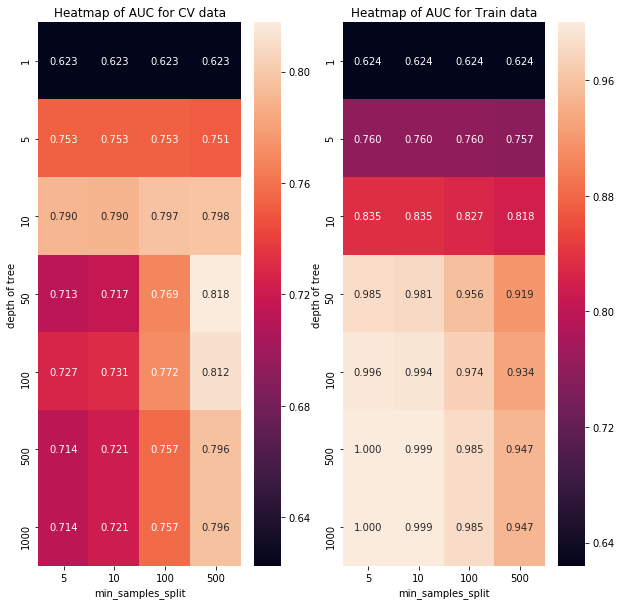

In [53]:
#Decision tree classifier for determining optimal depth and minimum samples split
depth, min_samples = clf(tfidfTrain,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)

AUC for Train data is   0.8402488188874389 

AUC for the Test data is   0.7568242778671864 



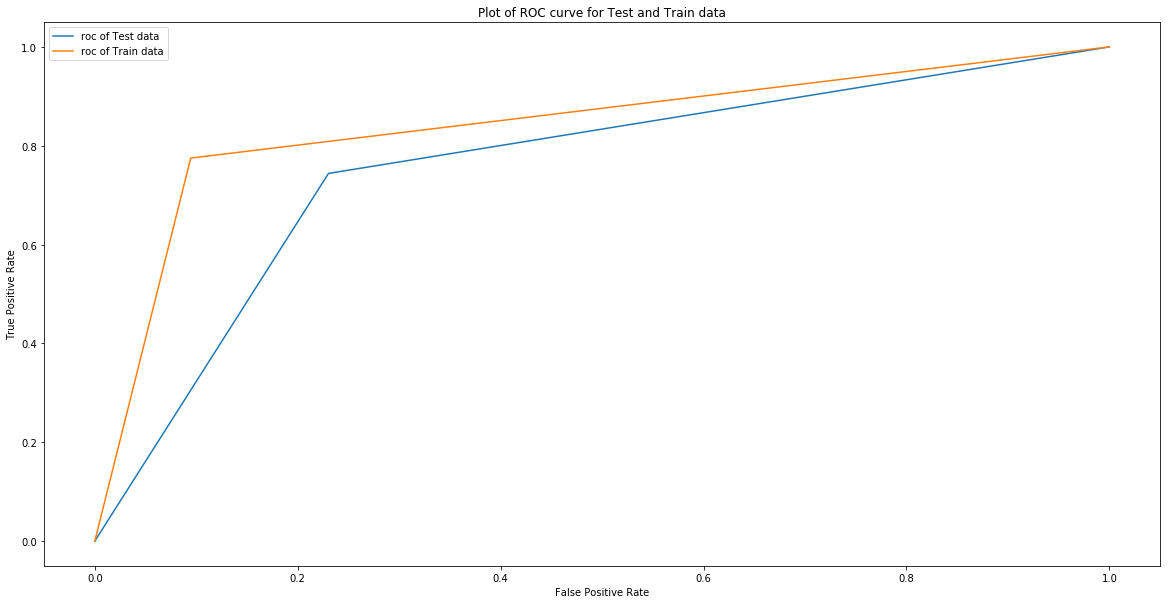

True positive rate = 74.40094899169632
True negative rate = 76.96390658174099


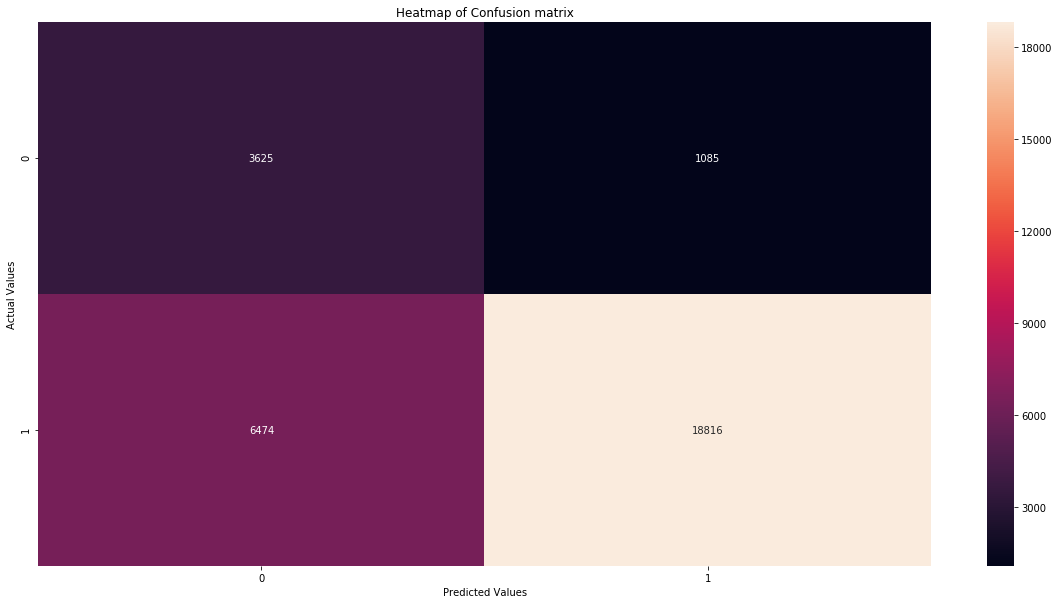

In [54]:
# Decision tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrain,AmazonReviewDataSampledTrain['Score'],tfidfTest,AmazonReviewDataSampledTest['Score'],min_samples,depth,tfidfVec,'tfidf.dot')
table.add_row(['TFIDF',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [55]:
# Printing the top 20 features of TFIDF vectorizer
TopFeatures(20,tfidfVec,coef)

20 Most important features in Positive and Negative Class
---------------------------------------------------------------------------------------------------------------------
+----------------+----------------+
| Feature Weight | Feature Name   |
+----------------+----------------+
|     0.1264     |      not       |
|     0.0858     |     great      |
|     0.057      |   disappoint   |
|     0.0543     |      love      |
|     0.0411     |      best      |
|     0.0405     |     delici     |
|     0.0238     |      good      |
|     0.022      |    perfect     |
|     0.0161     |    favorit     |
|     0.0132     |     excel      |
|     0.0126     |      bad       |
|     0.0119     | high recommend |
|     0.0116     |    not buy     |
|     0.0109     |    thought     |
|     0.0106     |      nice      |
|     0.0097     |      tast      |
|     0.009      |     tasti      |
|     0.0089     |      find      |
|     0.0088     |     worst      |
|     0.0075     |       aw     

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

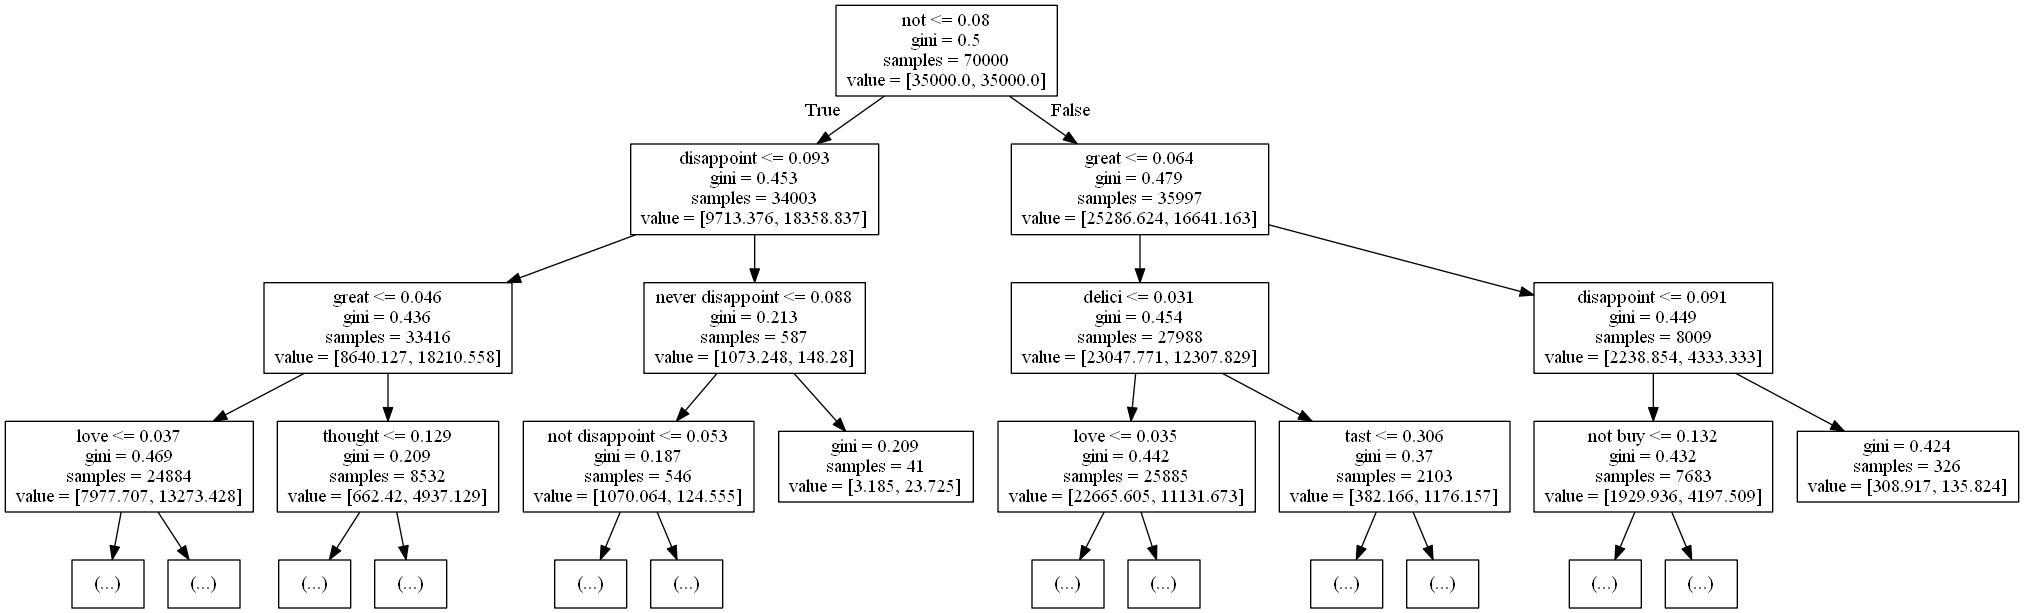

In [80]:
# Graph of DT for TFIDF vectorizer
Image("tfidf.png")

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

For depth = 1
min sample split = 5 , the auc for train data = 0.63554 and cv data = 0.61993
min sample split = 10 , the auc for train data = 0.63554 and cv data = 0.61993
min sample split = 100 , the auc for train data = 0.63554 and cv data = 0.61993
min sample split = 500 , the auc for train data = 0.63554 and cv data = 0.61993
For depth = 5
min sample split = 5 , the auc for train data = 0.79316 and cv data = 0.77594
min sample split = 10 , the auc for train data = 0.79316 and cv data = 0.77594
min sample split = 100 , the auc for train data = 0.79316 and cv data = 0.77594
min sample split = 500 , the auc for train data = 0.79316 and cv data = 0.77594
For depth = 10
min sample split = 5 , the auc for train data = 0.90562 and cv data = 0.76811
min sample split = 10 , the auc for train data = 0.90446 and cv data = 0.76852
min sample split = 100 , the auc for train data = 0.89023 and cv data = 0.78725
min sample split = 500 , the auc for train data = 0.8528 and cv data = 0.79955
For dep

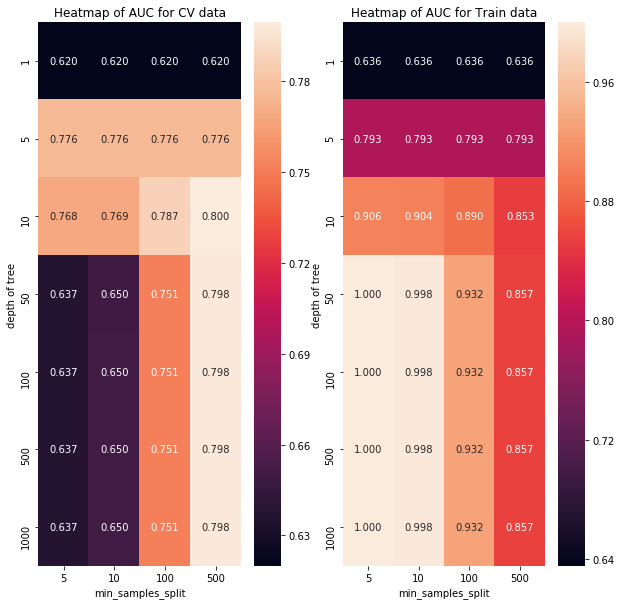

In [56]:
# Decision tree classifier to find the optimal depth and minimum samples split
depth, min_samples = clf(avgW2VTrain,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)

AUC for Train data is   0.7685650818116762 

AUC for the Test data is   0.7302739180915394 



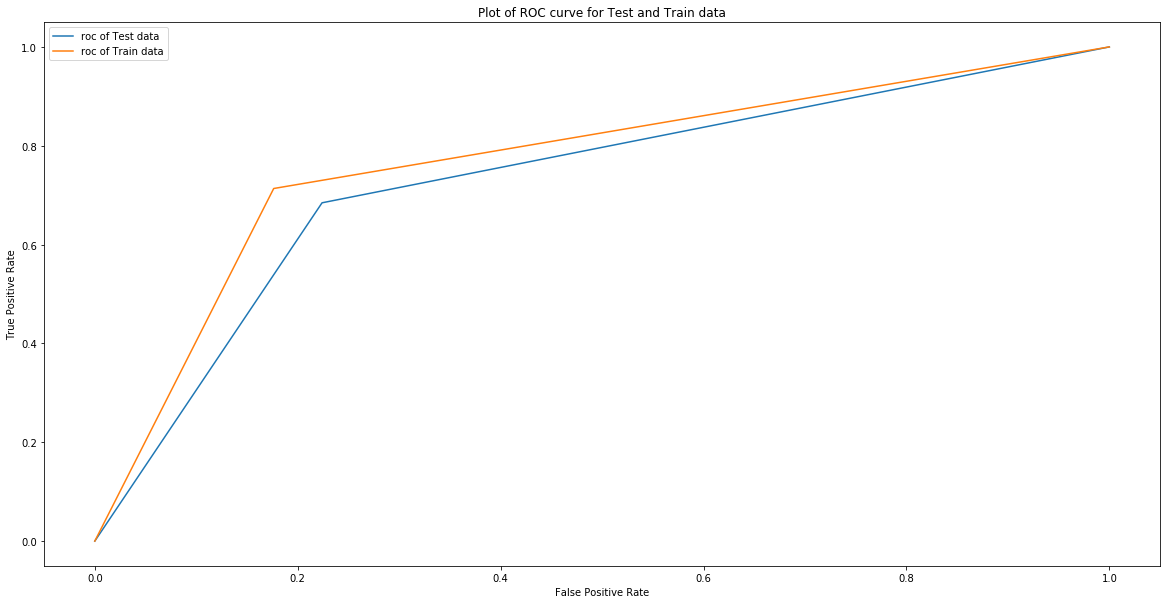

True positive rate = 68.45393436140768
True negative rate = 77.60084925690022


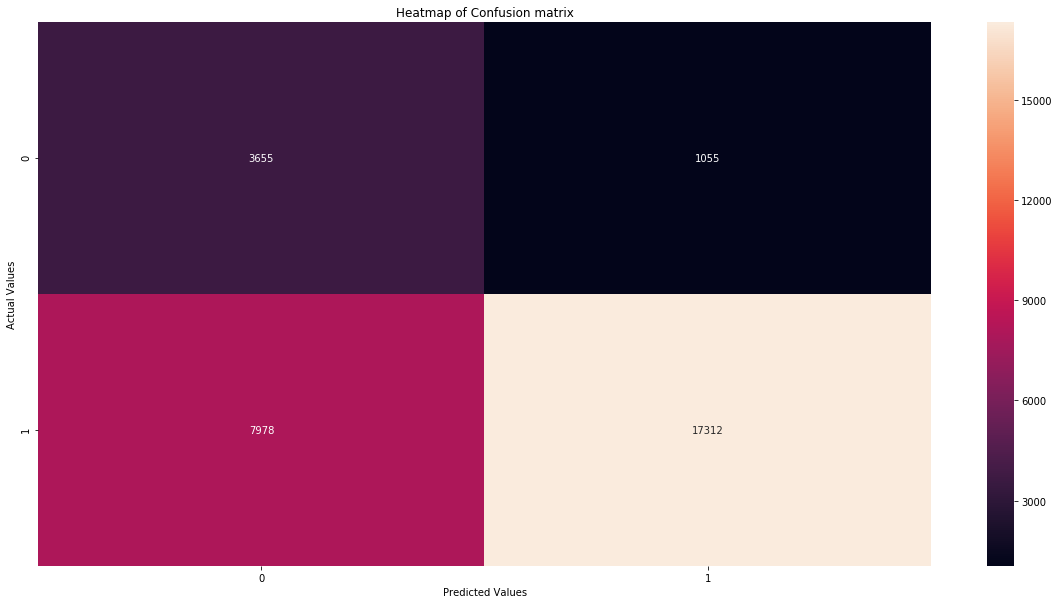

In [57]:
# decision tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrain,AmazonReviewDataSampledTrain['Score'],avgW2VTest,AmazonReviewDataSampledTest['Score'],min_samples,depth)
table.add_row(['AVG W2V',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

For depth = 1
min sample split = 5 , the auc for train data = 0.60885 and cv data = 0.608
min sample split = 10 , the auc for train data = 0.60885 and cv data = 0.608
min sample split = 100 , the auc for train data = 0.60885 and cv data = 0.608
min sample split = 500 , the auc for train data = 0.60885 and cv data = 0.608
For depth = 5
min sample split = 5 , the auc for train data = 0.75851 and cv data = 0.74171
min sample split = 10 , the auc for train data = 0.75851 and cv data = 0.74171
min sample split = 100 , the auc for train data = 0.75851 and cv data = 0.74171
min sample split = 500 , the auc for train data = 0.75851 and cv data = 0.74171
For depth = 10
min sample split = 5 , the auc for train data = 0.88579 and cv data = 0.73549
min sample split = 10 , the auc for train data = 0.88461 and cv data = 0.73555
min sample split = 100 , the auc for train data = 0.86734 and cv data = 0.75188
min sample split = 500 , the auc for train data = 0.82484 and cv data = 0.76353
For depth = 50

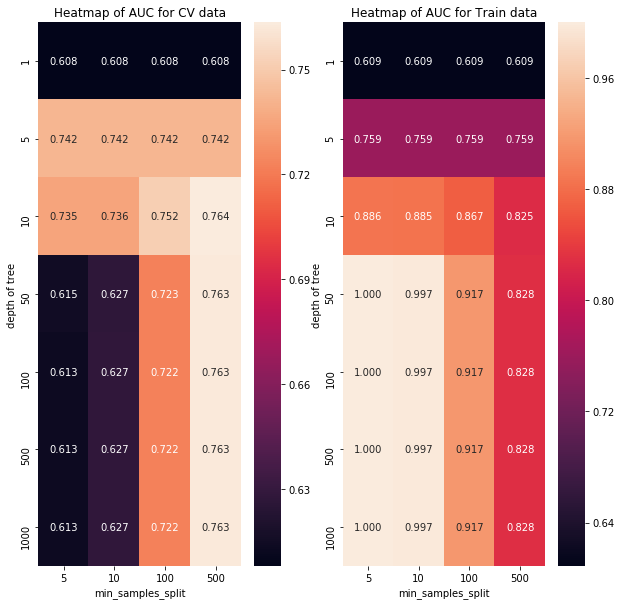

In [58]:
# Decision tree classifier to find the optimal depth and minimum samples split
depth, min_samples = clf(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)

AUC for Train data is   0.7441262789314561 

AUC for the Test data is   0.6952828715561903 



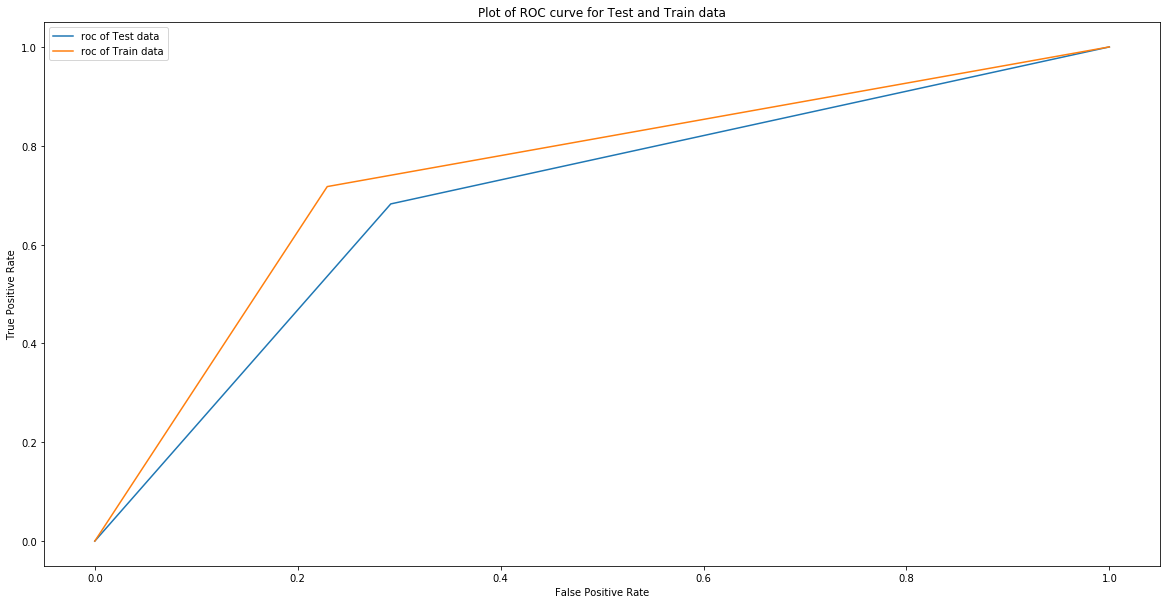

True positive rate = 68.22854883353105
True negative rate = 70.828025477707


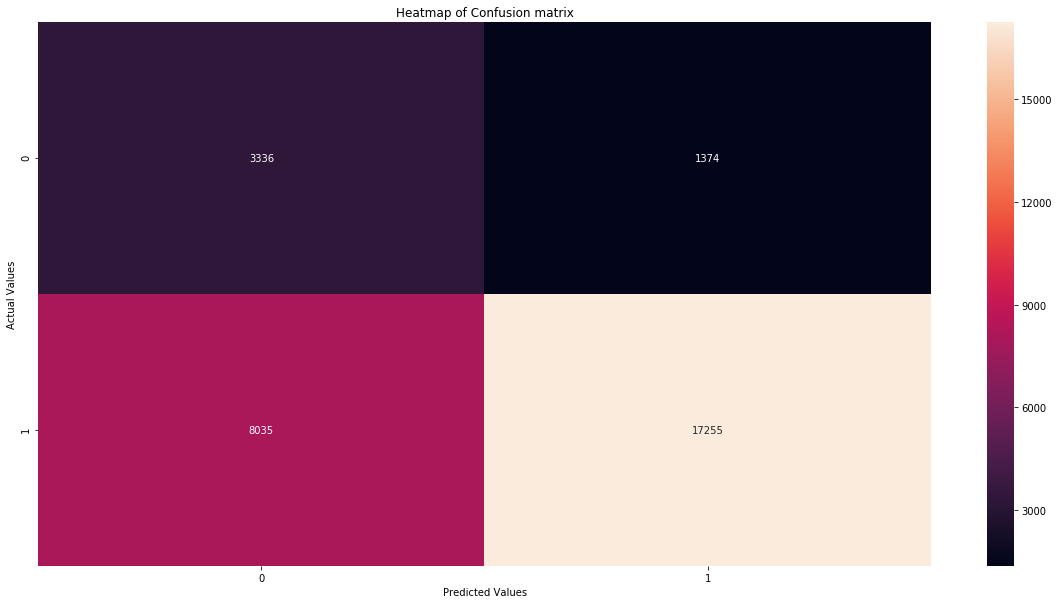

In [59]:
# decision tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],min_samples,depth)
table.add_row(['TFIDF W2V',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

# [6] Feature Engineering to improve the performance of decision tree model using summary and text review 

In [60]:
#Pretty table for summarizing the results
table2 = PrettyTable()
table2.field_names = ['Vectorizer','Optimal Depth','Min Samples Split','AUC','TPR','TNR']

## [6.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [61]:
#combining the bow for text and summary review
combined_features = FeatureUnion([( 'count_vec', bagofwords),('count_vec1',bagofwordsSum)])

bowTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
bowTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


For depth = 1
min sample split = 5 , the auc for train data = 0.62375 and cv data = 0.62148
min sample split = 10 , the auc for train data = 0.62375 and cv data = 0.62148
min sample split = 100 , the auc for train data = 0.62375 and cv data = 0.62148
min sample split = 500 , the auc for train data = 0.62375 and cv data = 0.62148
For depth = 5
min sample split = 5 , the auc for train data = 0.79824 and cv data = 0.79279
min sample split = 10 , the auc for train data = 0.79824 and cv data = 0.79281
min sample split = 100 , the auc for train data = 0.79811 and cv data = 0.79303
min sample split = 500 , the auc for train data = 0.79684 and cv data = 0.79352
For depth = 10
min sample split = 5 , the auc for train data = 0.87256 and cv data = 0.83049
min sample split = 10 , the auc for train data = 0.87185 and cv data = 0.83118
min sample split = 100 , the auc for train data = 0.86613 and cv data = 0.83769
min sample split = 500 , the auc for train data = 0.85837 and cv data = 0.84193
For de

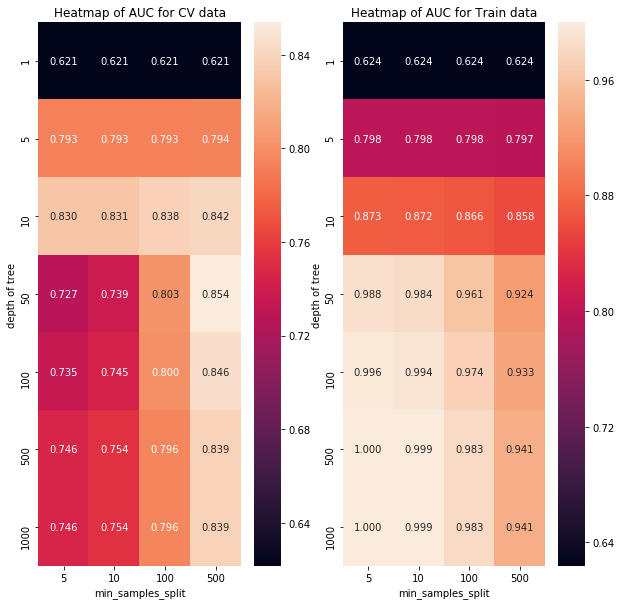

In [62]:
# Decision tree classifier to find the optimal depth and minimum sample split
depth, min_samples = clf(bowTrainFE,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)


AUC for Train data is   0.8481517220982733 

AUC for the Test data is   0.7951398176062139 



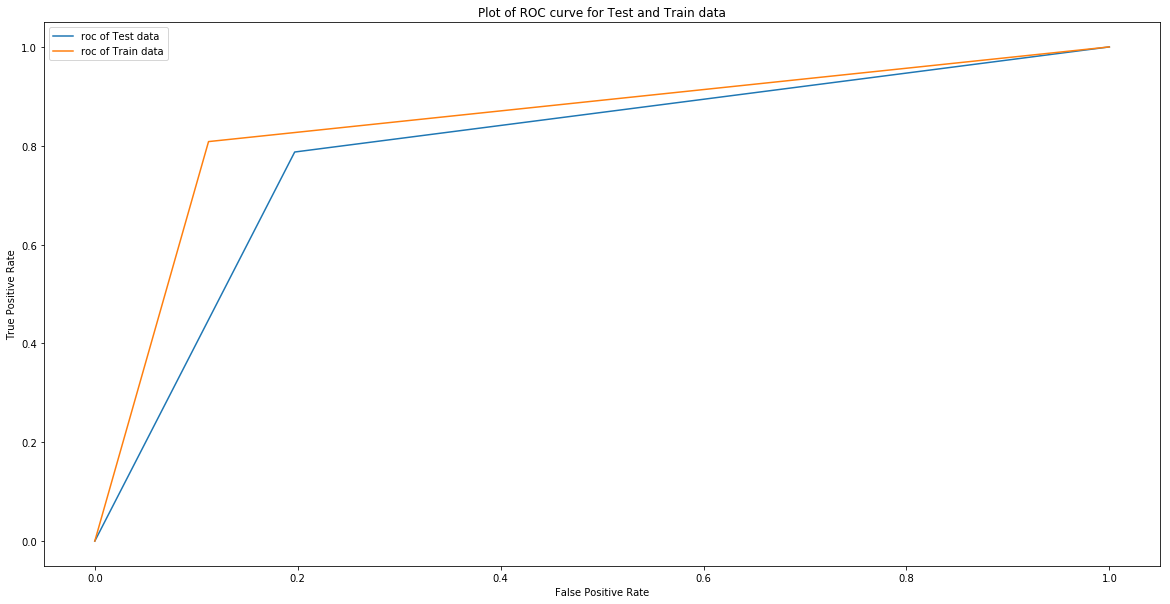

True positive rate = 78.73072360616845
True negative rate = 80.29723991507431


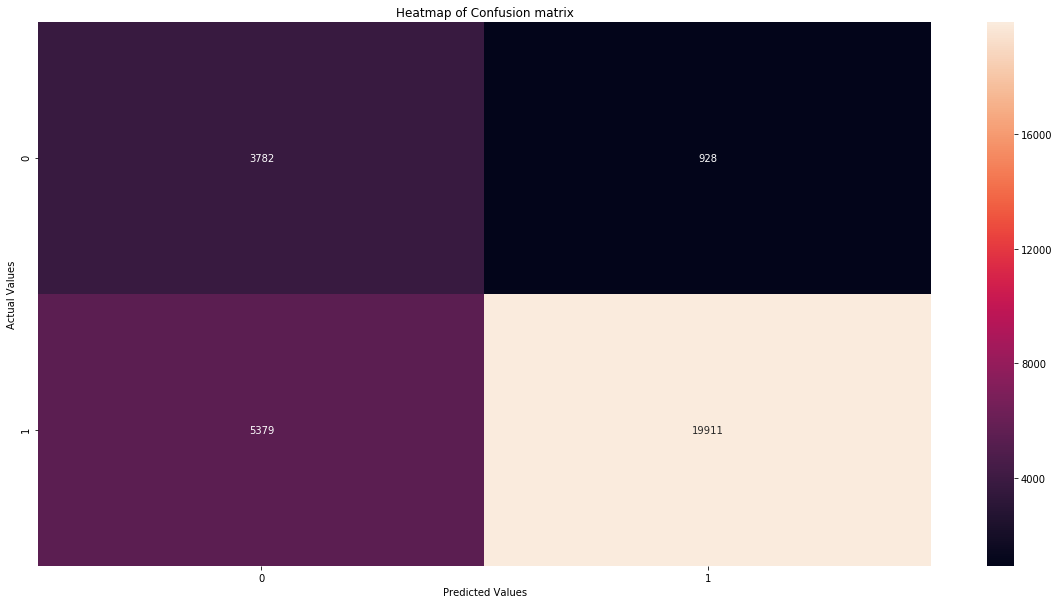

In [63]:
# Decision tree classing using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrainFE,AmazonReviewDataSampledTrain['Score'],bowTestFE,AmazonReviewDataSampledTest['Score'],min_samples,depth,combined_features,'bagwordsFE.dot')
table2.add_row(['Bag of Words',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [6.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [64]:
# printing the top 20 features of Bag of words vectorizer
TopFeatures(20,combined_features,coef)

20 Most important features in Positive and Negative Class
---------------------------------------------------------------------------------------------------------------------
+----------------+------------------------+
| Feature Weight |     Feature Name       |
+----------------+------------------------+
|     0.1475     |   count_vec1__great    |
|     0.1141     |    count_vec1__not     |
|     0.0491     |    count_vec1__love    |
|     0.0449     |    count_vec__best     |
|     0.0439     |     count_vec__not     |
|     0.0395     |   count_vec__delici    |
|     0.0357     |    count_vec1__good    |
|     0.0339     | count_vec__disappoint  |
|     0.0215     |    count_vec1__best    |
|     0.0204     | count_vec1__disappoint |
|     0.0191     |   count_vec1__excel    |
|     0.0183     |     count_vec__bad     |
|     0.0142     |   count_vec__favorit   |
|     0.0135     |   count_vec1__delici   |
|     0.0119     |  count_vec1__perfect   |
|     0.0106     |   count_vec__

### [6.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

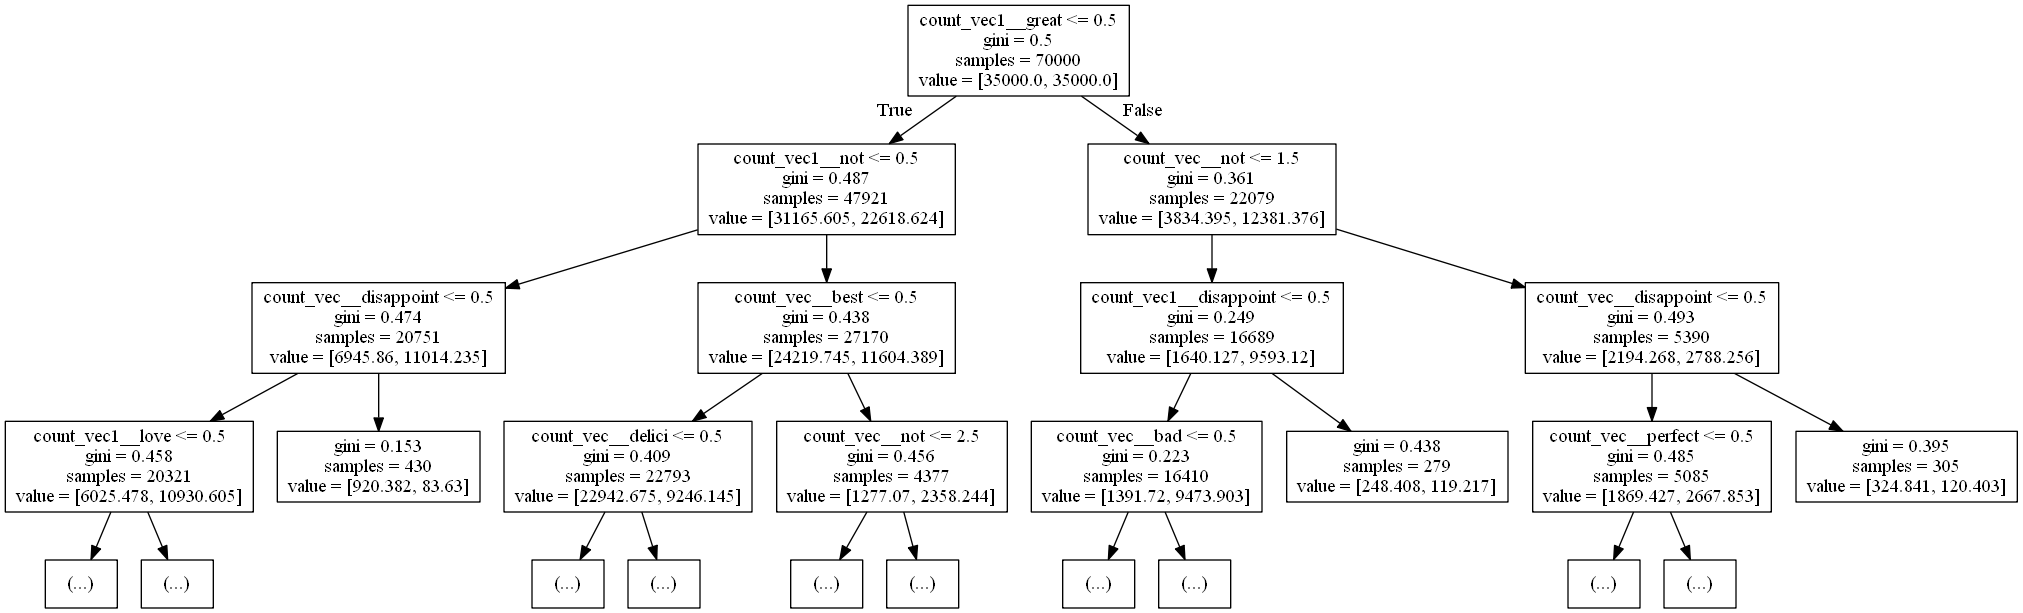

In [81]:
#Graph of Bag of words vectorizer
Image("bagwordsFE.png")

## [6.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [65]:
# combining the TFIDF of text and summary review
combined_features = FeatureUnion([( 'count_vec', tfidfVec),('count_vec1',tfidfVecSum)])

tfidfTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
tfidfTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


For depth = 1
min sample split = 5 , the auc for train data = 0.61896 and cv data = 0.61832
min sample split = 10 , the auc for train data = 0.61896 and cv data = 0.61832
min sample split = 100 , the auc for train data = 0.61896 and cv data = 0.61832
min sample split = 500 , the auc for train data = 0.61896 and cv data = 0.61832
For depth = 5
min sample split = 5 , the auc for train data = 0.80141 and cv data = 0.79372
min sample split = 10 , the auc for train data = 0.80141 and cv data = 0.79372
min sample split = 100 , the auc for train data = 0.80131 and cv data = 0.79405
min sample split = 500 , the auc for train data = 0.79854 and cv data = 0.79269
For depth = 10
min sample split = 5 , the auc for train data = 0.87957 and cv data = 0.83088
min sample split = 10 , the auc for train data = 0.8791 and cv data = 0.83128
min sample split = 100 , the auc for train data = 0.87274 and cv data = 0.83843
min sample split = 500 , the auc for train data = 0.8651 and cv data = 0.84107
For dept

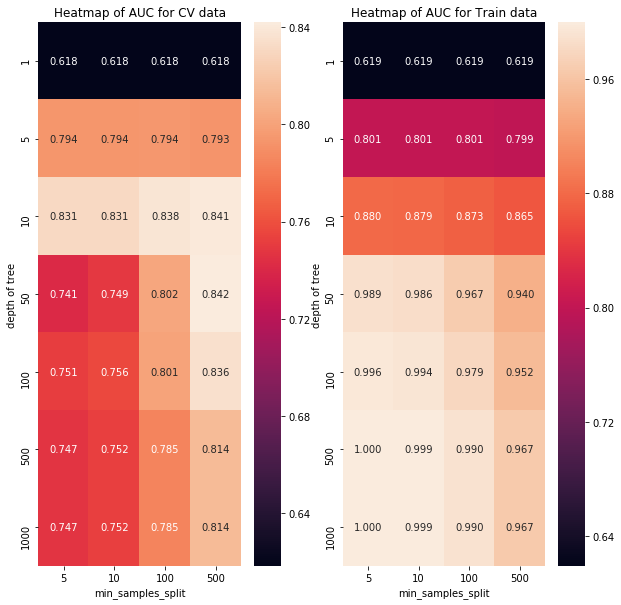

In [66]:
# Decision tree classifier to find the optimal depth and minimum samples split 
depth, min_samples = clf(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)

AUC for Train data is   0.8765690150757132 

AUC for the Test data is   0.7967986641581855 



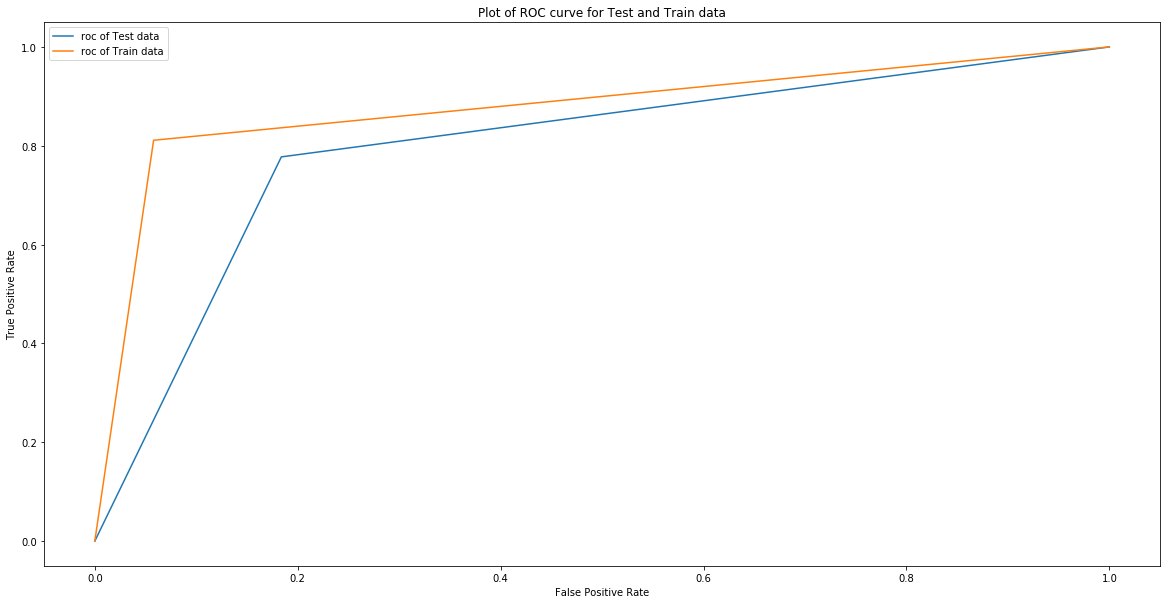

True positive rate = 77.74614472123369
True negative rate = 81.6135881104034


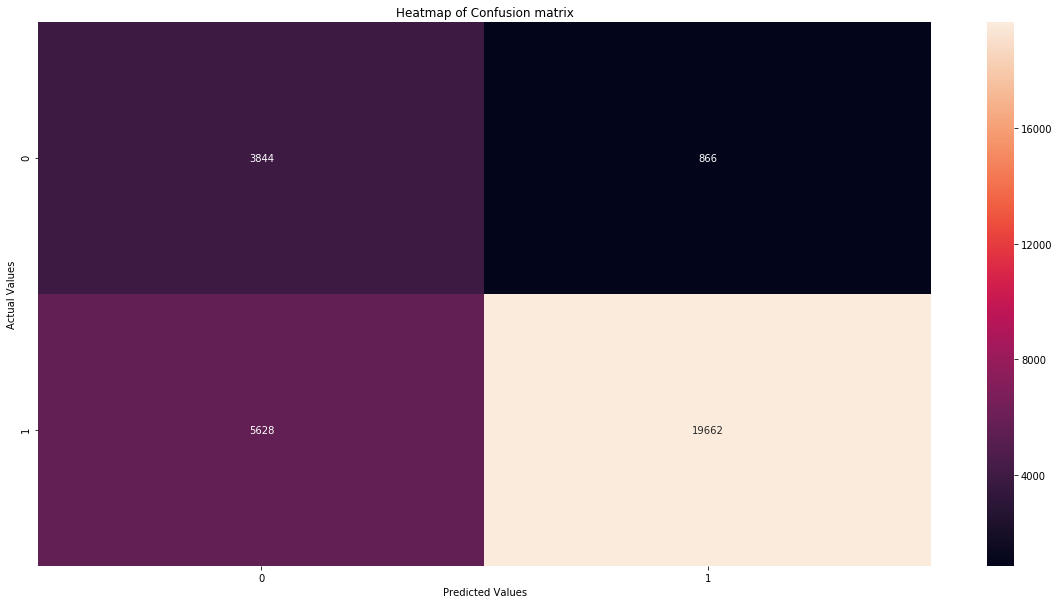

In [67]:
# Decision tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfTestFE,AmazonReviewDataSampledTest['Score'],min_samples,depth,combined_features,'tfidfFE.dot')
table2.add_row(['TFIDF',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [6.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [68]:
# Printing the top 20 features of TFIDF vectorizer
TopFeatures(20,combined_features,coef)

20 Most important features in Positive and Negative Class
---------------------------------------------------------------------------------------------------------------------
+----------------+------------------------+
| Feature Weight |     Feature Name       |
+----------------+------------------------+
|     0.1406     |   count_vec1__great    |
|     0.1116     |     count_vec__not     |
|     0.0607     |    count_vec__best     |
|     0.0493     |    count_vec1__love    |
|     0.0433     | count_vec__disappoint  |
|     0.0331     |    count_vec1__good    |
|     0.0309     |   count_vec__delici    |
|     0.0193     |   count_vec__perfect   |
|     0.0165     |   count_vec1__delici   |
|     0.0164     | count_vec1__not great  |
|     0.0109     |    count_vec__tasti    |
|     0.0104     |  count_vec1__not good  |
|     0.0098     |   count_vec__favorit   |
|     0.0097     |   count_vec1__excel    |
|     0.0084     |    count_vec1__bad     |
|     0.0081     |    count_vec_

### [6.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

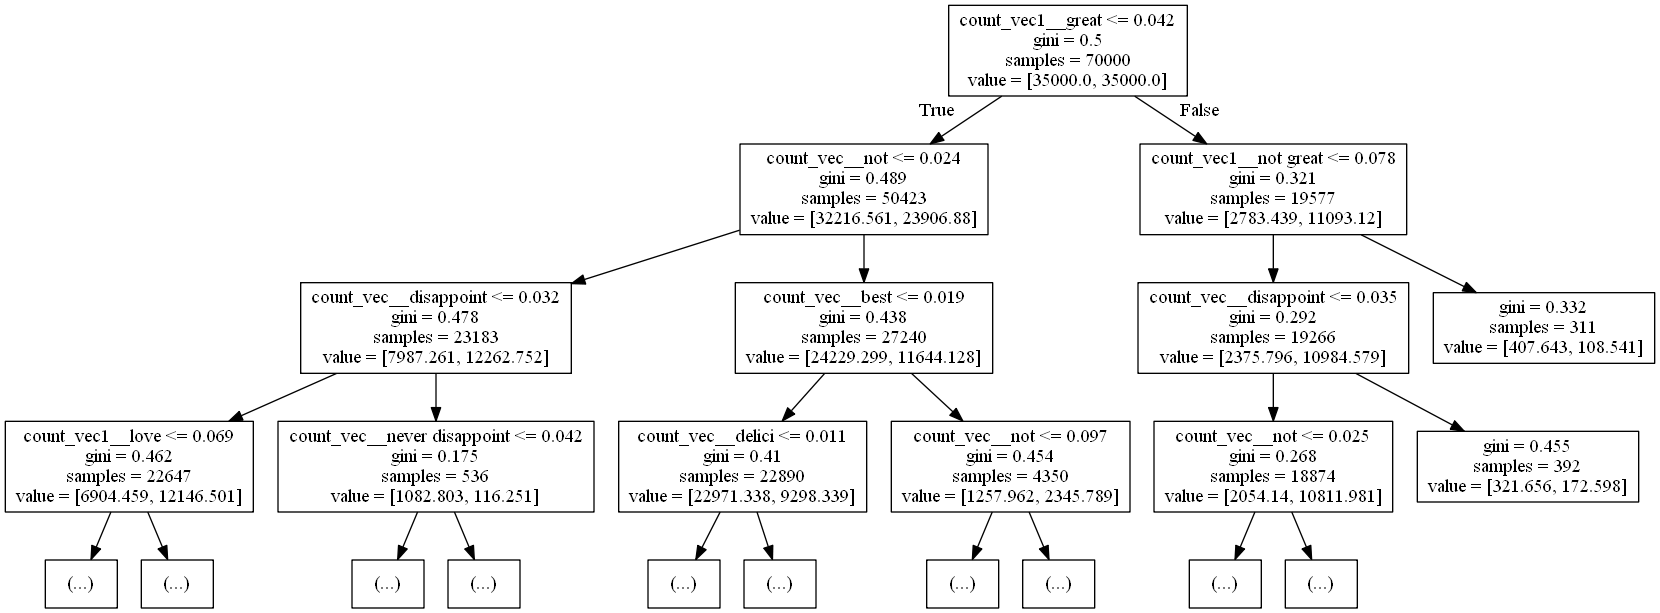

In [82]:
# Graph of TFIDF vectorizer
Image("tfidfFE.png")

## [6.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [69]:
#Combining the w2v of text and summary 
avgW2VTrainFE = np.concatenate((avgW2VTrain,avgW2VTrainSum),axis = 1)
avgW2VTestFE = np.concatenate((avgW2VTest,avgW2VTestSum),axis = 1)

For depth = 1
min sample split = 5 , the auc for train data = 0.70029 and cv data = 0.69996
min sample split = 10 , the auc for train data = 0.70029 and cv data = 0.69996
min sample split = 100 , the auc for train data = 0.70029 and cv data = 0.69996
min sample split = 500 , the auc for train data = 0.70029 and cv data = 0.69996
For depth = 5
min sample split = 5 , the auc for train data = 0.84853 and cv data = 0.83946
min sample split = 10 , the auc for train data = 0.84853 and cv data = 0.83946
min sample split = 100 , the auc for train data = 0.84845 and cv data = 0.83938
min sample split = 500 , the auc for train data = 0.84823 and cv data = 0.83923
For depth = 10
min sample split = 5 , the auc for train data = 0.93973 and cv data = 0.82501
min sample split = 10 , the auc for train data = 0.93892 and cv data = 0.82589
min sample split = 100 , the auc for train data = 0.92622 and cv data = 0.85592
min sample split = 500 , the auc for train data = 0.89953 and cv data = 0.86504
For de

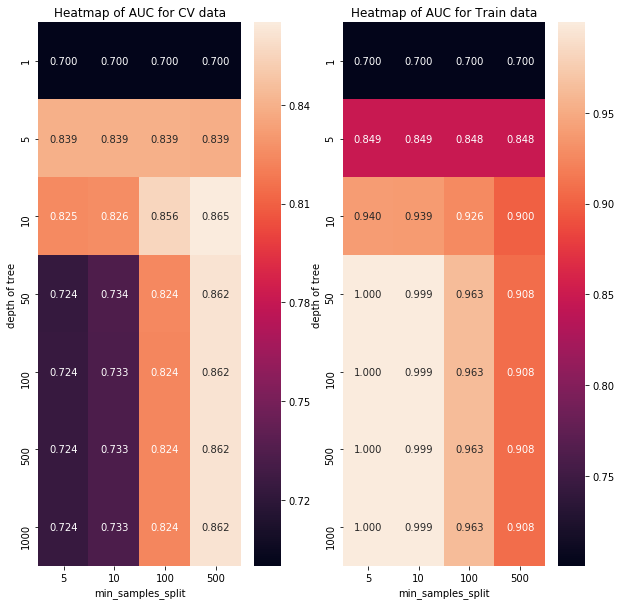

In [70]:
# Decision tree classifier to find the optimal depth and minimum samples split
depth, min_samples = clf(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)

AUC for Train data is   0.8212701183109415 

AUC for the Test data is   0.7861376189072995 



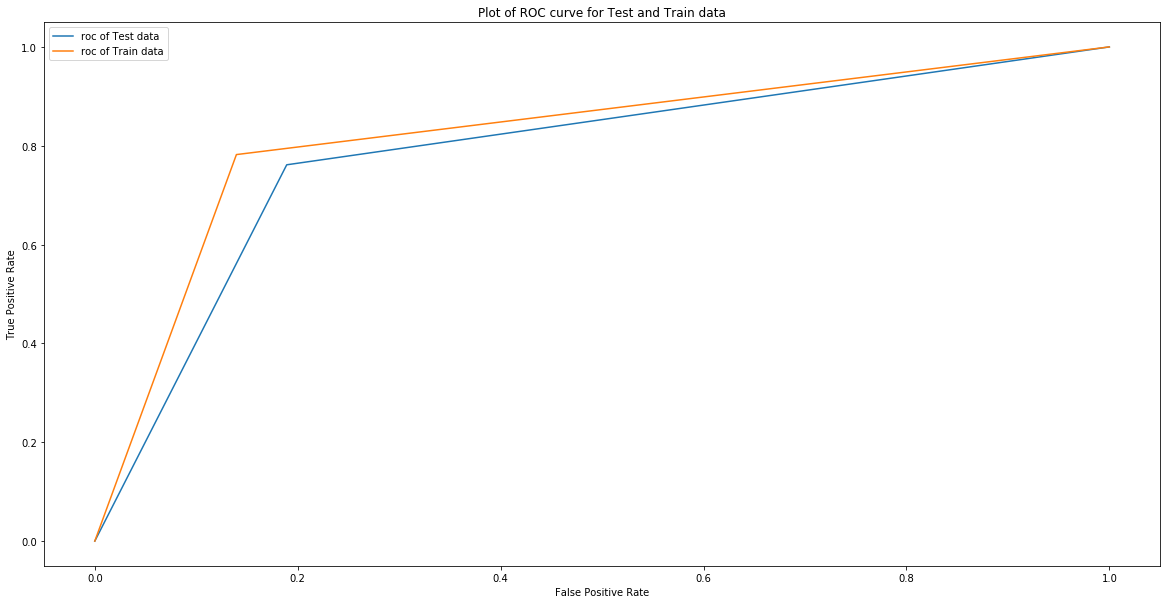

True positive rate = 76.14472123368921
True negative rate = 81.08280254777071


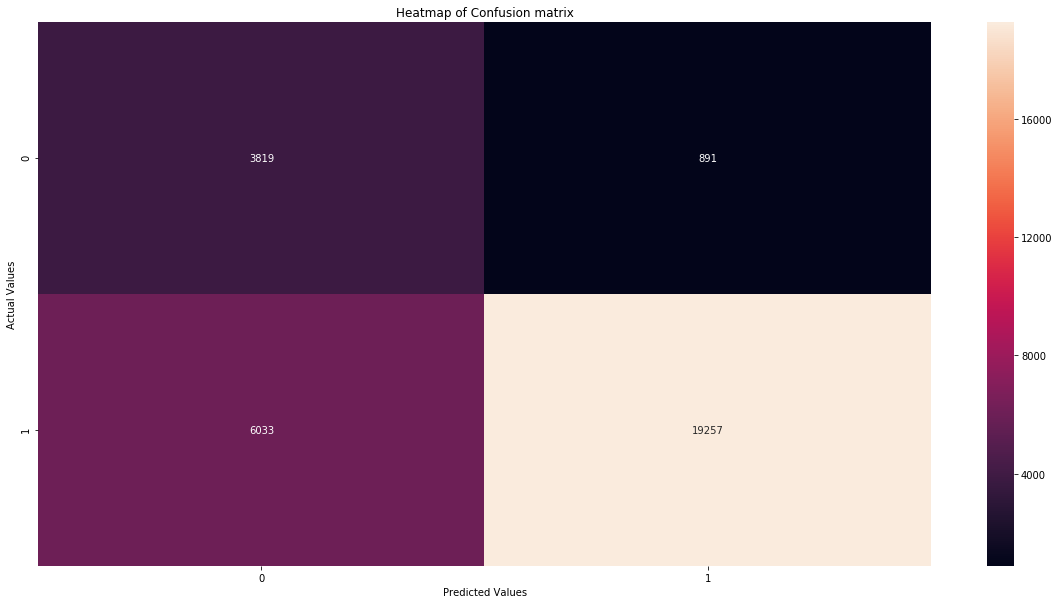

In [71]:
# Decision tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],avgW2VTestFE,AmazonReviewDataSampledTest['Score'],min_samples,depth)
table2.add_row(['AVG W2V',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

## [6.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [72]:
#combining the TFIDFW2V of text and summary review
tfidfw2vTrainFE = np.concatenate((tfidfw2vTrain,tfidfw2vTrainSum),axis = 1)
tfidfw2vTestFE = np.concatenate((tfidfw2vTest,tfidfw2vTestSum),axis = 1)

For depth = 1
min sample split = 5 , the auc for train data = 0.68518 and cv data = 0.68513
min sample split = 10 , the auc for train data = 0.68518 and cv data = 0.68513
min sample split = 100 , the auc for train data = 0.68518 and cv data = 0.68513
min sample split = 500 , the auc for train data = 0.68518 and cv data = 0.68513
For depth = 5
min sample split = 5 , the auc for train data = 0.82825 and cv data = 0.82046
min sample split = 10 , the auc for train data = 0.82825 and cv data = 0.82046
min sample split = 100 , the auc for train data = 0.82817 and cv data = 0.82038
min sample split = 500 , the auc for train data = 0.82784 and cv data = 0.82016
For depth = 10
min sample split = 5 , the auc for train data = 0.92842 and cv data = 0.81617
min sample split = 10 , the auc for train data = 0.92754 and cv data = 0.81671
min sample split = 100 , the auc for train data = 0.91441 and cv data = 0.83708
min sample split = 500 , the auc for train data = 0.88401 and cv data = 0.84752
For de

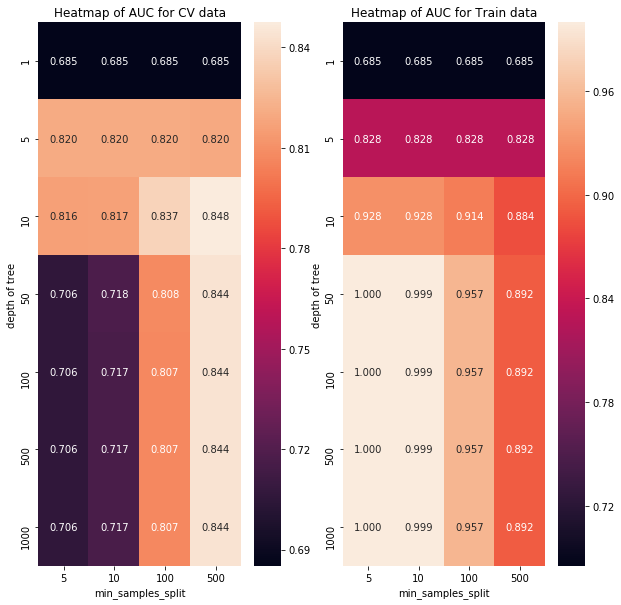

In [73]:
# Decision tree classifier to find the optimal depth and minimum samples split
depth, min_samples = clf(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'])
print('The optimal depth is %r and minimum samples split is %r'%(depth, min_samples))
print('='*117)

AUC for Train data is   0.8047140881875791 

AUC for the Test data is   0.770151465925204 



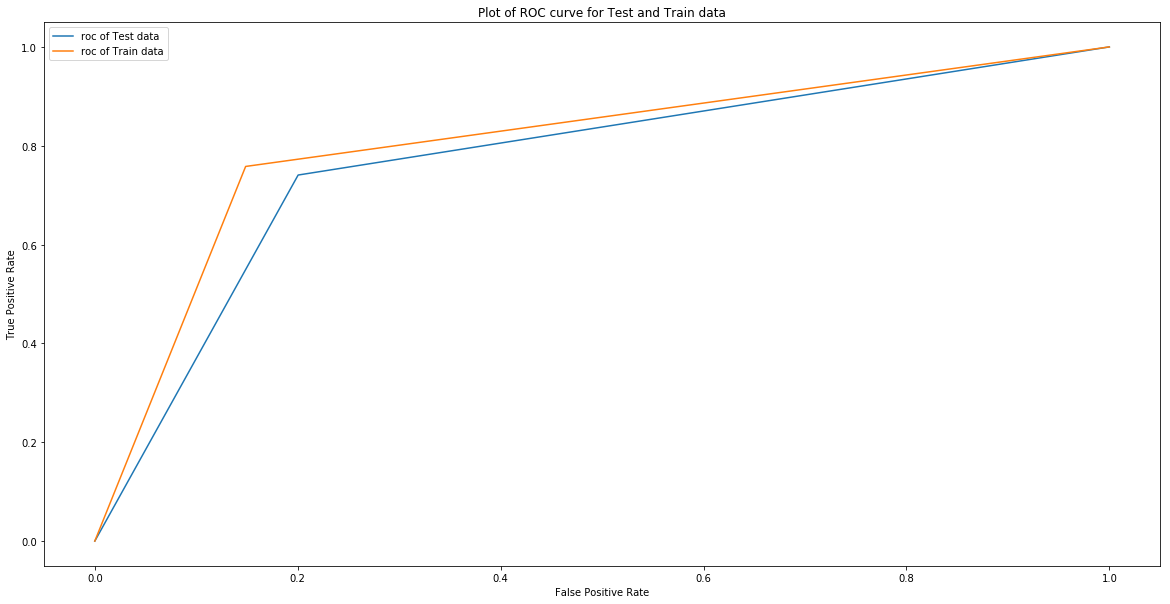

True positive rate = 74.0727560300514
True negative rate = 79.95753715498938


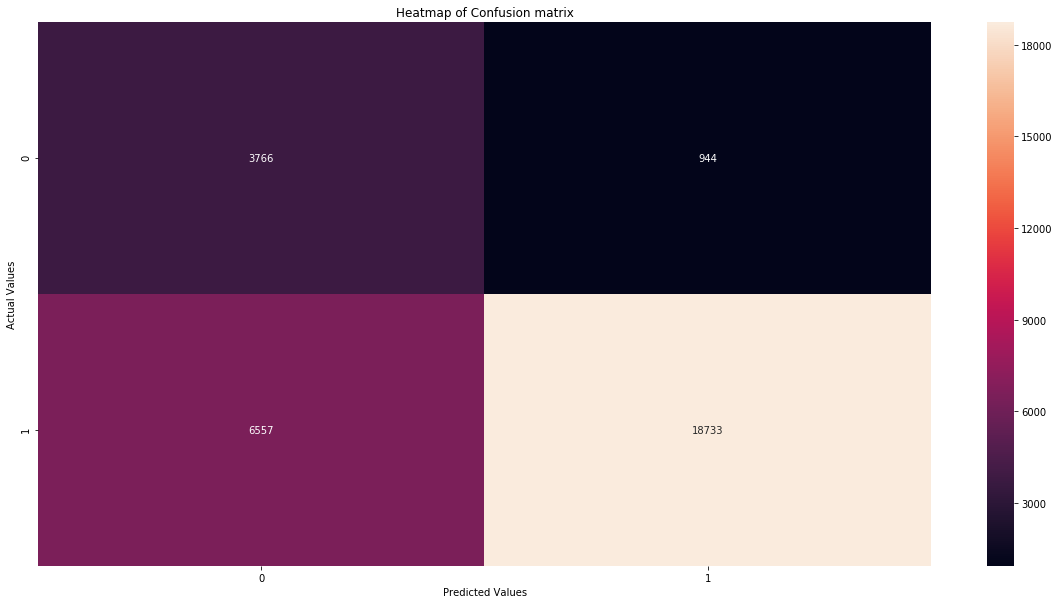

In [74]:
# decision tree classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfw2vTestFE,AmazonReviewDataSampledTest['Score'],min_samples,depth)
table2.add_row(['TFIDF W2V',depth,min_samples,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

# [7] Conclusions

In [75]:
print(table)# table of Decision tree with text review

+--------------+---------------+-------------------+--------+--------+--------+
|  Vectorizer  | Optimal Depth | Min Samples Split |  AUC   |  TPR   |  TNR   |
+--------------+---------------+-------------------+--------+--------+--------+
| Bag of Words |       50      |        500        | 0.7546 | 72.76  | 78.153 |
|    TFIDF     |       50      |        500        | 0.7568 | 74.401 | 76.964 |
|   AVG W2V    |       10      |        500        | 0.7303 | 68.454 | 77.601 |
|  TFIDF W2V   |       10      |        500        | 0.6953 | 68.229 | 70.828 |
+--------------+---------------+-------------------+--------+--------+--------+


Table showing the performance of decision tree classifier for different vectorizer.

### Observations:
TFIDF vectorizer performs well as compared to other vectorizers.
The performance of the decision tree can be improved by using Feature engineering.

In [76]:
print(table2)# table of decision tree with Feature engineering

+--------------+---------------+-------------------+--------+--------+--------+
|  Vectorizer  | Optimal Depth | Min Samples Split |  AUC   |  TPR   |  TNR   |
+--------------+---------------+-------------------+--------+--------+--------+
| Bag of Words |       50      |        500        | 0.7951 | 78.731 | 80.297 |
|    TFIDF     |       50      |        500        | 0.7968 | 77.746 | 81.614 |
|   AVG W2V    |       10      |        500        | 0.7861 | 76.145 | 81.083 |
|  TFIDF W2V   |       10      |        500        | 0.7702 | 74.073 | 79.958 |
+--------------+---------------+-------------------+--------+--------+--------+


Table showing the performance of decision tree classifier for different vectorizer using Feature Engineering. That by merging Text and Summary of the review.

### Observations:
TFIDF vectorizer has the best auc score as compared to other vectorizer. Also the TPR and TNR of TFIDF is better. We also note that the performane of decision tree classifier for all the vectorizers with Feature engineering  has improved.

# END
